In [31]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

df  = pd.read_csv("../datasets/creditcard1.csv")[:80_000] # need to ignore creditcard1.csv because it is too large to be pushed to github
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [32]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), #Fraud Cases=196'

In [33]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1000)
mod.fit(X, y).predict(X).sum()

172

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

# make a custom scoring function
def min_recall_precision(est, X, y_true, sample_weight=None): # sample_weight allows us to choose which row is more important
    y_pred = est.predict(X)
    # Do we care more about false negatives or false positives? Can tweak recall_score and precision_score
    recall = recall_score(y_true, y_pred) # Did I get all the fraud cases?
    precision = precision_score(y_true, y_pred) # Given that I predict fraud, how accurate am I?
    return min(recall, precision)

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score),
             'min_both': min_recall_precision},
    refit='min_both', # optimize for this metric
    return_train_score=True,
    cv=10, # higher means it takes longer to run, but more accurate
    n_jobs=-1
)
grid.fit(X, y); # can put a sample weight here

This is what make_scorer does. It changes the function signature, because sometimes you just want to call the function directly, sometimes you need GridSearchCV to call it.

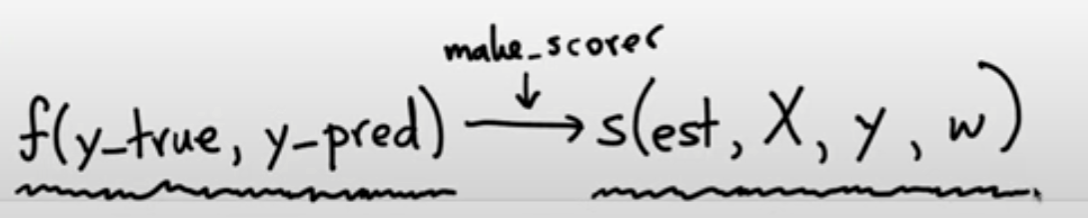

In [37]:
# the above min_recall_precision is the one that doesn't require make_scorer. This one does.
# def min_recall_precision(y_true, y_pred):
#     recall = recall_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred)
#     return min(recall, precision)

# make_scorer(min_recall_precision, greater_is_better=False)
# # ?make_scorer

make_scorer(min_recall_precision, greater_is_better=False, response_method='predict')

In [38]:
# s = make_scorer(min_recall_precision)
# ??s

Signature:       s(estimator, X, y_true, sample_weight=None, **kwargs)
Type:            _Scorer
String form:     make_scorer(min_recall_precision, response_method='predict')
File:            c:\users\andre\appdata\local\packages\pythonsoftwarefoundation.python.3.12_qbz5n2kfra8p0\localcache\local-packages\python312\site-packages\sklearn\metrics\_scorer.py
Source:         
class _Scorer(_BaseScorer):
    def _score(self, method_caller, estimator, X, y_true, **kwargs):
        """Evaluate the response method of `estimator` on `X` and `y_true`.

        Parameters
        ----------
        method_caller : callable
            Returns predictions given an estimator, method name, and other
            arguments, potentially caching results.

        estimator : object
            Trained estimator to use for scoring.

        X : {array-like, sparse matrix}
            Test data that will be fed to clf.decision_function or
            clf.predict_proba.

        y_true : array-like
        

Here's a summary for the test metrics.

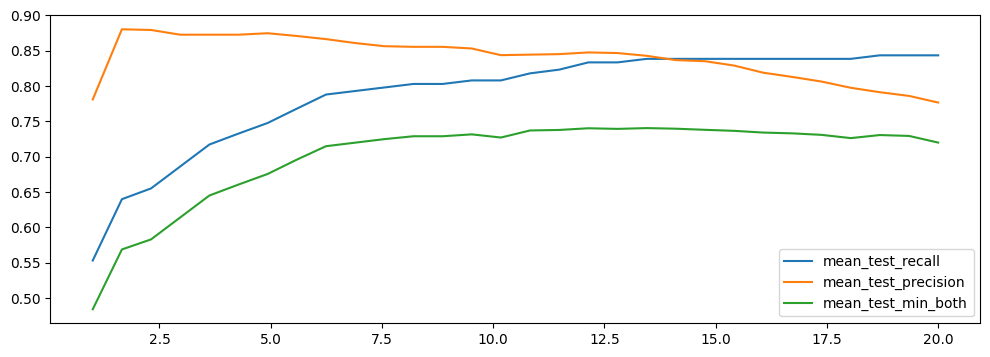

In [36]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']], 
             df_results[score], 
             label=score)
plt.legend();

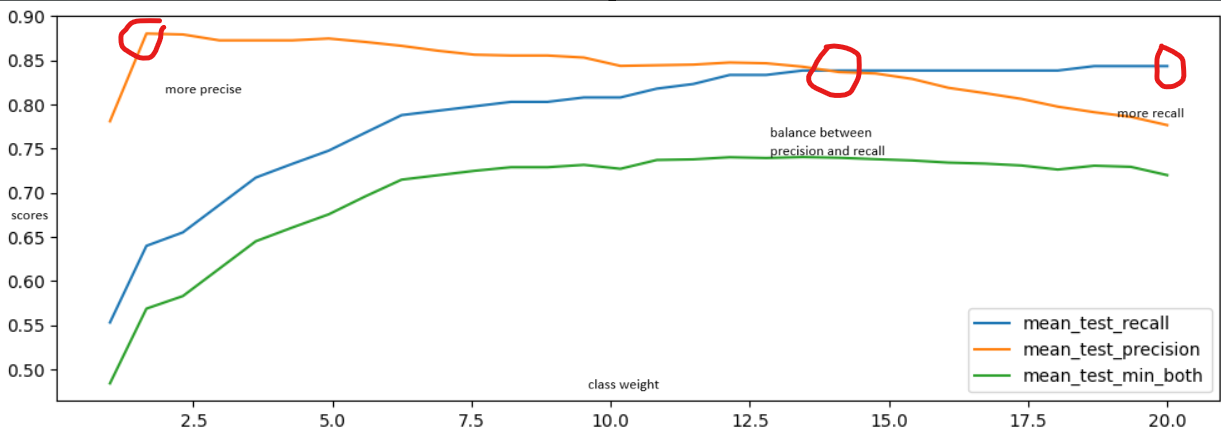

And here's the train metrics.

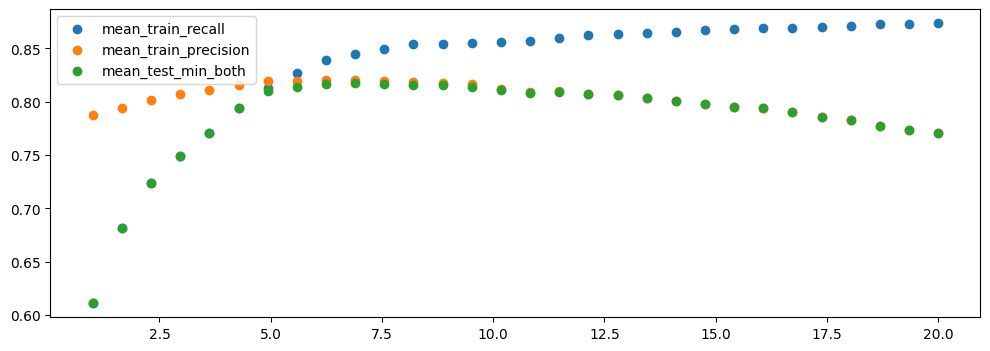

In [30]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_train_recall', 'mean_train_precision', 'mean_test_min_both']:
    plt.scatter(x=[_[1] for _ in df_results['param_class_weight']], 
                y=df_results[score.replace('test', 'train')], 
                label=score)
plt.legend();
# again, class weight on x, scores on y, but this time we are plotting the training scores

# Using Outlier Detection Models

In [ ]:
from collections import Counter
from sklearn.ensemble import IsolationForest
mod = IsolationForest().fit(X)
np.where(mod.predict(X) == -1, 1, 0) # translate -1 to 1, and 1 to 0. 1 means outlier, 0 means not outlier. 

And now in a gridsearch.

In [ ]:
def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == -1, 1, 0))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == -1, 1, 0))

grid = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={'contamination': np.linspace(0.001, 0.02, 10)},
    scoring={'precision': outlier_precision, 
             'recall': outlier_recall},
    refit='precision',
    cv=5,
    n_jobs=-1
)
grid.fit(X, y);

plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot(df_results['param_contamination'], 
             df_results[score], 
             label=score)
plt.legend();

In [ ]:
df = pd.DataFrame(grid.cv_results_)
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_recall'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_precision']);

In [ ]:
def min_pre_rec(y, y_true):
    return min(recall_score(y, y_true), precision_score(y, y_true))

In [ ]:
def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == 1, 0, 1))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == 1, 0, 1))

In [ ]:
grid = GridSearchCV(
    estimator=LogisticRegression(class_weight=10),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 40, t5)]},
    scoring={'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'min_pre_rec': make_scorer(min_pre_rec)},
    refit='precision',
    cv = 10,
    n_jobs=-1
)
grid.fit(X, y)

In [ ]:
df = pd.DataFrame(grid.cv_results_)
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_recall'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_precision'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_min_pre_rec']);

In [ ]:
_ = make_scorer(recall_score)

In [39]:
import numpy as np 

np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])